In [68]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'training_and_testing/train/train'
TEST_DIR = 'training_and_testing/test/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '10conv-basic')

In [69]:
def label_img(img):
    
    word_label = img.split('.')[-3]
    
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog': return [0, 1]

In [70]:
def create_train_data():
    
    training_data = []
    
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
        
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [71]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    np.save('test_data.npy', testing_data)
    return testing_data

In [72]:
# train_data = create_train_data()
# if you already have train data:
train_data = np.load('train_data.npy', allow_pickle=True)

In [73]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir = 'log')

In [74]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model loaded!')

INFO:tensorflow:Restoring parameters from D:\Users\Caerwin\Desktop\Robe con Jupyter\CNN-dogsvscats\dogsvscats-0.001-10conv-basic.model
Model loaded!


In [75]:
train = train_data[:-500]
test = train_data[-500:]

In [76]:
X = np.array([i[0]for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y =[i[1] for i in train]

test_x = np.array([i[0]for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y =[i[1] for i in test]

In [77]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.30282 | time: 23.947s
| Adam | epoch: 005 | loss: 0.30282 - acc: 0.8618 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.31963 | time: 25.041s
| Adam | epoch: 005 | loss: 0.31963 - acc: 0.8568 | val_loss: 0.43937 - val_acc: 0.8140 -- iter: 24500/24500
--


In [78]:
model.save(MODEL_NAME)

INFO:tensorflow:D:\Users\Caerwin\Desktop\Robe con Jupyter\CNN-dogsvscats\dogsvscats-0.001-10conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


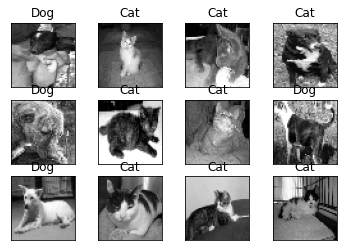

In [86]:
import matplotlib.pyplot as plt

# if you don't have this file yet
#test_data = process_test_data()
# if you already have it
test_data = np.load('test_data.npy', allow_pickle = 'True')

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    # cat: [1, 0]
    # dog: [0, 1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label = 'Dog'
    else: str_label = 'Cat'
    
    y.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

In [90]:
with open('submission-file.csv', 'w') as f:
    f.write('id, label\n')

In [91]:
with open('submission-file.csv', 'a') as f:
    for data in tqdm(test_data):
        
        img_num = data[1]
        img_data = data[0]

        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)

        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:13<00:00, 958.68it/s]
